In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from textblob import TextBlob

sns.set(style='whitegrid')

In [2]:
df = pd.read_csv("/content/covid19_tweets.csv")
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         5475 non-null   object
 1   user_location     4385 non-null   object
 2   user_description  5184 non-null   object
 3   user_created      5475 non-null   object
 4   user_followers    5475 non-null   int64 
 5   user_friends      5475 non-null   int64 
 6   user_favourites   5475 non-null   int64 
 7   user_verified     5475 non-null   bool  
 8   date              5475 non-null   object
 9   text              5475 non-null   object
 10  hashtags          3823 non-null   object
 11  source            5475 non-null   object
 12  is_retweet        5474 non-null   object
 13  cleaned_text      5475 non-null   object
 14  sentiment         5475 non-null   int64 
dtypes: bool(1), int64(4), object(10)
memory usage: 604.3+ KB
None

Sentiment Distribution:
sent

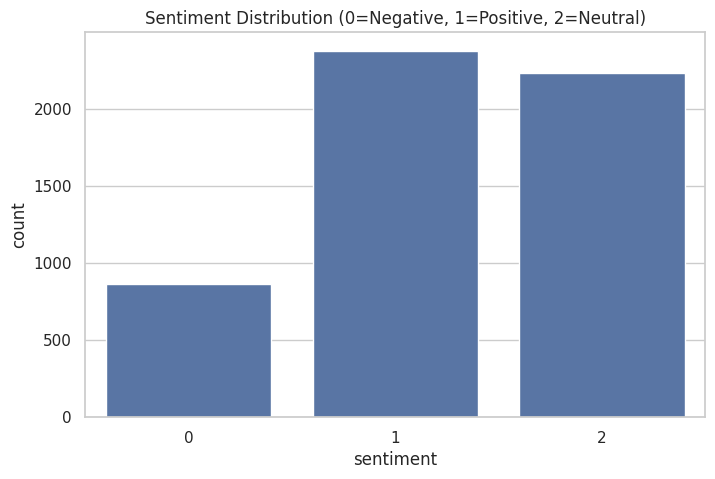

In [3]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 1  # Positive
    elif analysis.sentiment.polarity == 0:
        return 2  # Neutral
    else:
        return 0  # Negative

df['sentiment'] = df['cleaned_text'].apply(get_sentiment)

print("\nDataset Info:")
print(df.info())

print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution (0=Negative, 1=Positive, 2=Neutral)')
plt.show()



Logistic Regression Results:
Accuracy: 0.7842835130970724
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.20      0.33       173
           1       0.77      1.00      0.87       476

    accuracy                           0.78       649
   macro avg       0.87      0.60      0.60       649
weighted avg       0.83      0.78      0.73       649



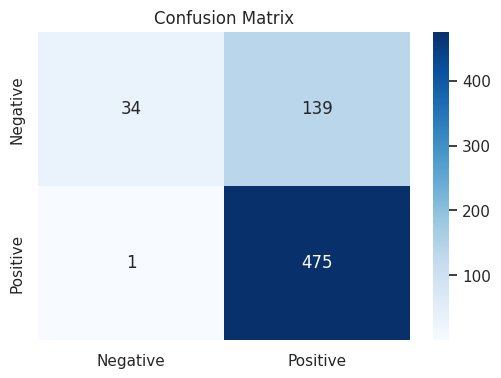

In [4]:
df = df[df['sentiment'] != 2]

X = df['cleaned_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred = lr_model.predict(X_test_tfidf)

print("\nLogistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.show()

In [7]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

print("\nTraining LSTM Model...")
history = lstm_model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)


Training LSTM Model...
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - accuracy: 0.7121 - loss: 0.6124 - val_accuracy: 0.7654 - val_loss: 0.5451
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.7288 - loss: 0.5857 - val_accuracy: 0.7654 - val_loss: 0.5480
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.7408 - loss: 0.5736 - val_accuracy: 0.7654 - val_loss: 0.5581



LSTM Model Accuracy: 0.7334


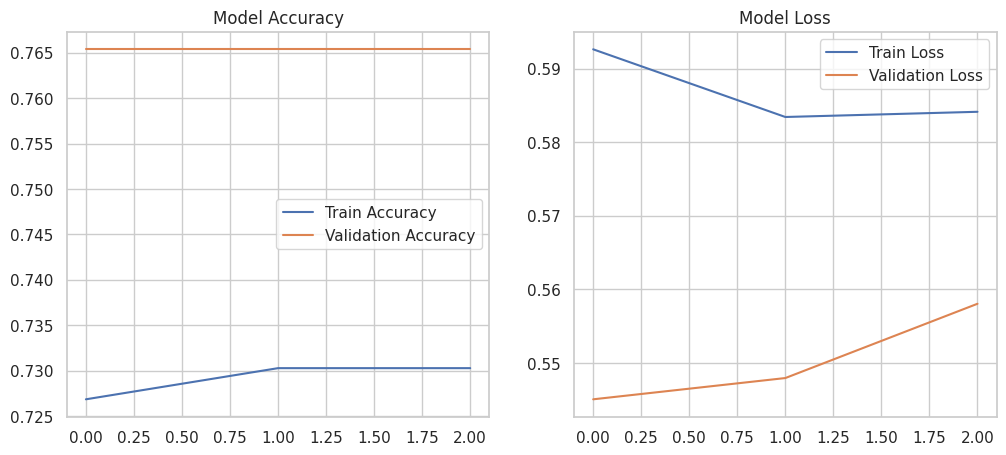

In [8]:
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\nLSTM Model Accuracy: {lstm_acc:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()